In [3]:
!pip install numpy==1.21
!pip install dtreeviz
!pip install kneed
!pip install pyreadstat
!pip install visualkeras
!pip install keras_tuner
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import csv
import statistics
from math import inf
import random


#Visualización
import matplotlib.pyplot as plt
from seaborn import color_palette
import seaborn as sns

#modelos y métricas
from sklearn import metrics
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, precision_score, auc, roc_auc_score, mean_squared_error, silhouette_score, classification_report,mean_absolute_error, max_error, median_absolute_error, r2_score, explained_variance_score


#preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Pickle
import pickle
import pyreadstat

# Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import visualkeras
import keras_tuner as kt

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Redes Neuronales

Creamos los datasets.

In [5]:
url = 'https://drive.google.com/file/d/1ziV8Kmuw_Vtv7aX1zGnfMdoLMd0nfoOr/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

ds_train = pd.read_csv(path)

url = 'https://drive.google.com/file/d/1j34_hlvFOJV_8TN2jdnV2GXSArfWlUUK/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

ds_test = pd.read_csv(path)

In [6]:
de_temp_train = ds_train.copy()

de_temp_train.loc[ds_train["tipo_precio"]=="bajo", "target"]= 0
de_temp_train.loc[ds_train["tipo_precio"]=="medio", "target"]= 1
de_temp_train.loc[ds_train["tipo_precio"]=="alto", "target"]= 2

Asignamos valores numéricos a los tipos de precio para trabajar con ellos.

In [7]:
de_temp_test = ds_test.copy()

de_temp_test.loc[ds_test["tipo_precio"]=="bajo", "target"]= 0
de_temp_test.loc[ds_test["tipo_precio"]=="medio", "target"]= 1
de_temp_test.loc[ds_test["tipo_precio"]=="alto", "target"]= 2

In [8]:
ds_train_x = de_temp_train.drop(['id', 'tipo_precio', 'property_price', 'target'], axis='columns', inplace=False)
ds_test_x = de_temp_test.drop(['id', 'tipo_precio', 'property_price', 'target'], axis='columns', inplace=False)

In [9]:
ds_train_rn_x = pd.get_dummies(ds_train_x, columns=["barrio","property_type"], drop_first=True)
ds_test_rn_x = pd.get_dummies(ds_test_x, columns=["barrio","property_type"], drop_first=True)

## Regresion

In [10]:
ds_train_rn_y = de_temp_train['property_price'].copy()
ds_test_rn_y = de_temp_test['property_price'].copy()

In [11]:
columnas_predictoras=ds_train_rn_x.columns.to_list()

d_in=len(columnas_predictoras)

Estandarizamos y escalamos los datos.

In [12]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(ds_train_rn_x))

StandardScaler()

In [13]:
x_train_transform=sscaler.transform(pd.DataFrame(ds_train_rn_x))
x_test_transform=sscaler.transform(pd.DataFrame(ds_test_rn_x))

#### Modelo de una capa


Entrenamos un modelo usando keras de una capa para regresión.

In [14]:
rn = keras.Sequential([keras.layers.Dense(1,input_shape=(d_in,))])

In [15]:
rn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 79        
                                                                 
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [16]:
rn.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
  loss='mse', 
  metrics=['mae'], 
)

In [17]:
rn.fit(x_train_transform,ds_train_rn_y,epochs=10,batch_size=16,verbose=False)

In [18]:
pred = rn.predict(x_test_transform)

500/500 [==============================] - 1s 1ms/step


In [19]:
mae=mean_absolute_error(ds_test_rn_y,pred)
mse=mean_squared_error(ds_test_rn_y,pred)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")

Error absoluto medio 216483.477021418
Error cuadrático medio 127312474563.47418


In [22]:
# Guardamos el modelo
import pickle

filename = 'rn_reg.sav'
pickle.dump(rn, open(filename, 'wb'))

#### Modelo multicapa

Entrenamos keras secuencial de varias capas para regresión.

In [23]:
d_out=1

rn = keras.Sequential([
    keras.layers.Dense(3,input_shape=(d_in,), activation="relu"),
    keras.layers.Dense(6, activation="tanh" ),
    keras.layers.Dense(d_out, "sigmoid")])

In [24]:
rn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 237       
                                                                 
 dense_2 (Dense)             (None, 6)                 24        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 268
Trainable params: 268
Non-trainable params: 0
_________________________________________________________________


In [25]:
rn.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
  loss='mse', 
  metrics=['mae'], 
)

In [26]:
rn.fit(x_train_transform,ds_train_rn_y,epochs=10,batch_size=16,verbose=False)

In [27]:
y_pred=rn.predict(x_test_transform)

mae=mean_absolute_error(ds_test_rn_y,y_pred)
mse=mean_squared_error(ds_test_rn_y,y_pred)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")

500/500 [==============================] - 1s 1ms/step
Error absoluto medio 216511.92879024698
Error cuadrático medio 127358774601.02214


Se puede observar que aumentando la cantidad de capas de la red no se obtiene una mejora, por el contrario, el error aumenta. Por lo tanto, en este caso nos podemos quedar con un modelo de una única capa

In [30]:
# Guardamos el modelo
filename = 'rn_multi_reg.sav'
pickle.dump(rn, open(filename, 'wb'))

## Clasificacion


In [31]:
ds_train_rn_y = de_temp_train['target'].copy()
ds_test_rn_y = de_temp_test['target'].copy()

Hacemos una busqueda de hiperparametros

In [32]:
random.seed(1)
activations = ['relu', 'tanh', 'sigmoid', 'softmax']

mejores_hyperparametros = {
    'func_activacion_1': '',
    'func_activacion_2': '',
    'func_activacion_3': '',
    'epochs': 0,
    'batch_size': 0,
}

mejores_metricas = inf

for i in range(0,5):

  cant_salidas = random.randint(0,3)
  func_activacion_1 = activations[random.randint(0,3)]
  func_activacion_2 = activations[random.randint(0,3)]
  func_activacion_3 = activations[random.randint(0,3)]
  modelo = keras.Sequential([
      # input_shape solo en la primer capa
      keras.layers.Dense(1, input_shape=(d_in,), activation=activations[random.randint(0,3)]),

      keras.layers.Dense(cant_salidas, activation=func_activacion_1),
      keras.layers.Dense(cant_salidas, activation=func_activacion_2),

      keras.layers.Dense(1, activation=func_activacion_3),
     ])

  # Compilamos el modelo
  modelo.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999), 
  loss='mse', 
  metrics=['mae'], 
  )
  
  # Entrenamiento del modelo
  epochs = random.randint(50,150)
  batch_size = random.randint(50,200)

  print(f"Probando con: {cant_salidas} salidas, {func_activacion_1}, {func_activacion_2}, {func_activacion_3}, {epochs} epochs, {batch_size} batch_size")
  history = modelo.fit(x_train_transform, ds_train_rn_y,epochs=epochs,batch_size=batch_size,verbose=False)

  y_pred = modelo.predict(x_test_transform)

  y_pred = y_pred.flatten()
  mse = metrics.mean_squared_error(
        y_true  = ds_test_rn_y,
        y_pred  = y_pred,
        squared = True
        )
      
  print("Metricas obtenidas:")
  print(f"mse:{mse}")
  print()

  if mse < mejores_metricas:
    mejores_metricas = mse

    mejores_hyperparametros['cant_salidas'] = cant_salidas
    mejores_hyperparametros['func_activacion_1'] = func_activacion_1
    mejores_hyperparametros['func_activacion_2'] = func_activacion_2
    mejores_hyperparametros['func_activacion_3'] = func_activacion_3
    mejores_hyperparametros['epochs'] = epochs
    mejores_hyperparametros['batch_size'] = batch_size
  

print(mejores_metricas)
print(mejores_hyperparametros)


Probando con: 1 salidas, relu, sigmoid, relu, 147 epochs, 165 batch_size
500/500 [==============================] - 1s 1ms/step
Metricas obtenidas:
mse:0.6670012104920617

Probando con: 3 salidas, softmax, tanh, relu, 53 epochs, 149 batch_size
500/500 [==============================] - 1s 1ms/step
Metricas obtenidas:
mse:0.6669583781684852

Probando con: 3 salidas, relu, softmax, sigmoid, 125 epochs, 76 batch_size
500/500 [==============================] - 1s 2ms/step
Metricas obtenidas:
mse:0.5284800284175839

Probando con: 2 salidas, relu, relu, relu, 98 epochs, 105 batch_size
500/500 [==============================] - 1s 1ms/step
Metricas obtenidas:
mse:0.42645220278499735

Probando con: 3 salidas, relu, tanh, softmax, 120 epochs, 109 batch_size
500/500 [==============================] - 1s 1ms/step
Metricas obtenidas:
mse:0.6669584244778505

0.42645220278499735
{'func_activacion_1': 'relu', 'func_activacion_2': 'relu', 'func_activacion_3': 'relu', 'epochs': 98, 'batch_size': 105, '

In [33]:
columnas_predictoras=ds_train_rn_x.columns.to_list()

d_in=len(columnas_predictoras)

In [34]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(ds_train_rn_x))

StandardScaler()

In [35]:
x_train_transform=sscaler.transform(pd.DataFrame(ds_train_rn_x))
x_test_transform=sscaler.transform(pd.DataFrame(ds_test_rn_x))

In [36]:
# calcula la cantidad de clases
classes=int(de_temp_train.loc[:,'target'].max()+1)

modelo = keras.Sequential([
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(7, activation='softmax'),
    keras.layers.Dense(classes, activation='sigmoid')])

modelo.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 3)                 237       
                                                                 
 dense_25 (Dense)            (None, 7)                 28        
                                                                 
 dense_26 (Dense)            (None, 3)                 24        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [37]:
modelo.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
  loss='sparse_categorical_crossentropy', 
  metrics=['accuracy'], 
)

cant_epochs=125

historia = modelo.fit(x_train_transform,ds_train_rn_y,epochs=cant_epochs,batch_size=76,verbose=False)

In [38]:
y_pred = modelo.predict(x_test_transform)

y_pred = np.argmax(y_pred,axis = 1)

500/500 [==============================] - 1s 1ms/step


              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68      5336
         1.0       0.47      0.47      0.47      5327
         2.0       0.71      0.64      0.68      5332

    accuracy                           0.61     15995
   macro avg       0.61      0.61      0.61     15995
weighted avg       0.61      0.61      0.61     15995

Accuracy: 0.608127539856205
 


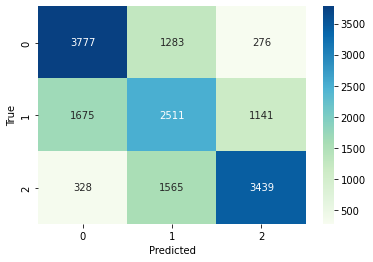

In [39]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(ds_test_rn_y,y_pred)

print(classification_report(ds_test_rn_y,y_pred))
print("Accuracy: "+str(accuracy))
print(" ")

#Creo la matriz de confusión
tabla=confusion_matrix(ds_test_rn_y, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
# Guardamos el modelo
filename = 'rn_multi_clf.sav'
pickle.dump(modelo, open(filename, 'wb'))

Por los resultados de la matriz de confusión podemos inferir que nuestro modelo roza el underfitting ya que no se ajusta a los datos de entrenamiento y por eso apenas puede predecir bien la mitad de los datos de testing.

## Conclusiones

Sabemos que las redes neuronales pueden ser una herramienta muy valiosa al momento de entrenar un modelo y predecir datos, aunque en nuestro caso los resultados no fueron muy buenos. Al igual que con el primer trabajo practico nos inclinamos a pensar que la causa del mal desempeño es debido a nuestro set de datos que no es del todo bueno. 
Aun haciendo una busqueda de hiperparametros los resultados de la combinacion optima no son muy buenos.

